# Kainos challange- Preprocessing

Beside file containing information about bus delay (train.csv) there are additional files: stops.csv, stopsintrips.csv, weather.csv with information that may be useful for prediction. The aim of preprocessing phase is to review all existing files, merge them properly, get rid of unnecessary data, deal with missing values and outliers.

### Train file

I'll start with importing train csv. file and reviewing it. As there are more than 8 million rows in train file for analysis purpose I'll use a sample of 500000 rows.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline
import pandas_profiling

C:\Users\Natalia\Miniconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# set column types to minimize filed size (checked earlier what types to choose)
column_types= {'id': 'int32',
               'stopId': 'int32',
               'routeId': 'int16',
               'vehicleId': 'int32',
               'tripId': 'int16',
               'delayInSeconds': 'int32',
               'agencyId': 'int8',
               }

In [3]:
# read csv file, change type of columns with dates to datetime format
n = len(open('train.csv').readlines())
s = 500000 #desired sample size
skip = sorted(random.sample(range(2,n),n-s))
df = pd.read_csv('train.csv', skiprows=skip, dtype=column_types, parse_dates=['delayPredictionTimestamp','scheduleTime'])
print ('Datafile has ' + str(n) + ' rows.')

Datafile has 8248505 rows.


In [4]:
# check DataFrame shape
df.shape

(499999, 8)

In [5]:
# have a look on sampled rows
df.sample(5)

,id,stopId,routeId,vehicleId,tripId,delayPredictionTimestamp,scheduleTime,delayInSeconds
387982,6506967,2146,12,390,31,2018-07-13 19:40:39,2018-07-13 19:43:00,1323
464556,7763748,1491,148,195,22,2018-07-21 14:44:08,2018-07-21 14:30:00,912
477769,7983374,38480,10605,143624,211,2018-07-22 14:08:12,2018-07-22 14:07:00,92
115850,2012425,150,131,150,12,2018-06-22 14:19:58,2018-06-22 14:35:00,6
302468,5096074,2123,3,141565,11,2018-07-07 18:12:48,2018-07-07 18:14:00,-12


In [6]:
# check data types and missing info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499999 entries, 0 to 499998
Data columns (total 8 columns):
id                          499999 non-null int32
stopId                      499999 non-null int32
routeId                     499999 non-null int16
vehicleId                   499999 non-null int32
tripId                      499999 non-null int16
delayPredictionTimestamp    499999 non-null datetime64[ns]
scheduleTime                499999 non-null datetime64[ns]
delayInSeconds              499999 non-null int32
dtypes: datetime64[ns](2), int16(2), int32(4)
memory usage: 17.2 MB


In [7]:
# check if there are duplicated rows
df.duplicated().any()

False

In df there is a dependant variable 'delayInSeconds' and 7 columns with possible features. There are no missing values nor duplicates.

### Stops file

In [8]:
# read csv file
stops=pd.read_csv('stopsintrips.csv', dtype=column_types)

In [9]:
# check DataFrame shape
stops.shape

(22458, 6)

In [10]:
# have a look on sampled rows
stops.sample(5)

,agencyId,routeId,stopId,stopSequence,tripId,topologyVersionId
17640,8,10180,33190,3,71,621
5637,6,10141,32530,0,31,626
14233,1,269,176,0,122,623
4330,1,124,1447,10,11,623
3660,1,199,1355,15,61,623


In [11]:
# check data types and missing info
stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22458 entries, 0 to 22457
Data columns (total 6 columns):
agencyId             22458 non-null int8
routeId              22458 non-null int16
stopId               22458 non-null int32
stopSequence         22458 non-null int64
tripId               22458 non-null int16
topologyVersionId    22458 non-null int64
dtypes: int16(2), int32(1), int64(2), int8(1)
memory usage: 548.3 KB


In [12]:
# check if there are duplicated rows
stops.duplicated(subset=['stopId','routeId','tripId']).any()

False

There are 3 same columns as in df: 'routeId', 'stopId', 'tripId' and 3 new columns. There are no missing values nor duplicates.
Let's check which column to use as a key for merging DataFrames

In [13]:
# check number of unique values in each column
stops.nunique()

agencyId               10
routeId               191
stopId               2495
stopSequence          105
tripId                 75
topologyVersionId      10
dtype: int64

Number of unique values in each column is smaller than number of rows. None of the columns contains unique values only and can be separately used as key for merge. Let's check 3 Id columns together.

In [14]:
# check if there are any duplicates in combination of 'routeId', 'stopId', 'tripId'
stops[['routeId', 'stopId', 'tripId' ]].duplicated().any()

False

Combination of 'routeId', 'stopId', 'tripId' is unique and can be used as a key for merge. I'll merge the DataFrames

In [15]:
# merge DataFrames
df=df.merge(right=stops, how='left', on=['routeId','stopId', 'tripId'])

In [16]:
# check if there are any missing values after merge, if so what percentage it is.
missing_data = pd.DataFrame(df.isnull().any(), columns=['Nulls'])
missing_data['Num_of_nulls [qty]'] = pd.DataFrame(df.isnull().sum())
missing_data['Num_of_nulls [%]'] = round((df.isnull().mean()*100),2)
missing_data

,Nulls,Num_of_nulls [qty],Num_of_nulls [%]
id,False,0,0.00
stopId,False,0,0.00
routeId,False,0,0.00
vehicleId,False,0,0.00
tripId,False,0,0.00
delayPredictionTimestamp,False,0,0.00
scheduleTime,False,0,0.00
delayInSeconds,False,0,0.00
agencyId,True,24458,4.89
stopSequence,True,24458,4.89


There are almost 5% of data missing in merged rows. Let's look for the best way to fill it.

In [17]:
# check number of unique 'agencyId','stopSequence','topologyVersionId' values per routeId
stops.groupby('routeId')['agencyId','stopSequence','topologyVersionId'].nunique().sample(5)

,agencyId,stopSequence,topologyVersionId
routeId,,,
10165,1,24,1
10170,1,18,1
10180,1,21,1
10287,1,19,1
10326,1,23,1


Realized that 'agencyId' and 'topologyVersionId' values are unique for every routeId. Those two columns may be merged with df using 'routeId' as an only key. I'll drop those 2 columns from df and merge it again using routeId. To do that I'll create another DataFrame with unique rows of 'routeId','agencyId','topologyVersionId'.

In [18]:
df.drop(['agencyId','topologyVersionId'], axis=1, inplace=True)
stops_2=stops[['routeId','agencyId','topologyVersionId']].drop_duplicates()
df=df.merge(right=stops_2, how='left', on=['routeId'])

In [19]:
# check missing data
missing_data = pd.DataFrame(df.isnull().any(), columns=['Nulls'])
missing_data['Num_of_nulls [qty]'] = pd.DataFrame(df.isnull().sum())
missing_data['Num_of_nulls [%]'] = round((df.isnull().mean()*100),2)
missing_data

,Nulls,Num_of_nulls [qty],Num_of_nulls [%]
id,False,0,0.00
stopId,False,0,0.00
routeId,False,0,0.00
vehicleId,False,0,0.00
tripId,False,0,0.00
delayPredictionTimestamp,False,0,0.00
scheduleTime,False,0,0.00
delayInSeconds,False,0,0.00
stopSequence,True,24458,4.89
agencyId,True,6956,1.39


Missing data of 'agencyId' and 'topologyVersionId' was reduced to 1.4%. Let's fill remaining missing values. I'll analyze 'stopSequence' first.

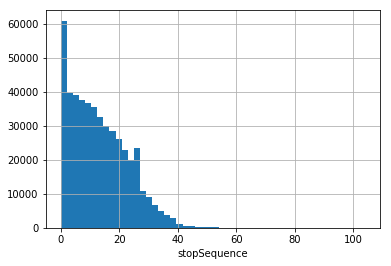

In [20]:
# check distibution of 'stopSequence'
df['stopSequence'].dropna().astype('int').hist(bins=50)
plt.xlabel('stopSequence')

In [21]:
# check median value
df['stopSequence'].median()

12.0

Distribution is strongly right skewed with median equal to 12. Let's see how median 'delayInSeconds' look like for each 'stopSequence'

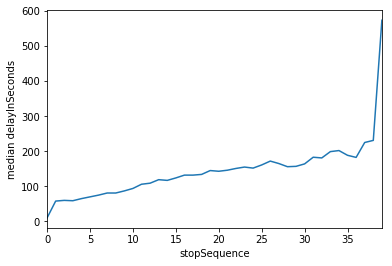

In [22]:
# draw median 'delayInSeconds' from each 'stopSequence'. For better view 'stopSequence' outliers removed from graph
df[df['stopSequence']<40].groupby('stopSequence')['delayInSeconds'].median().plot()
plt.ylabel('median delayInSeconds')

The higher 'stopSequence' the more delayed buses are. It seems reasonable to replace missing 'stopSequence' with it's median value of 12. 

In [23]:
# fill missing 'stopSequence' with it's median value of 12. 
df['stopSequence']=df['stopSequence'].fillna(12)

I'll check distribution of AgencyId. This columns contain Id of bus agency. Even though it's numeric the numbers itself are not meaningful, it's a categorical feature so I'll draw a bar chart to see distribution.

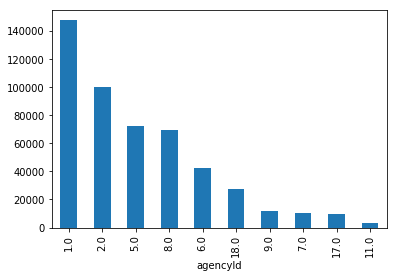

In [24]:
# plot distribution of 'agencyId'
df['agencyId'].value_counts().plot.bar()
plt.xlabel('agencyId')

I decided to fill missing 'agencyId' with most common and therefore most probable value of 1

In [25]:
df['agencyId']=df['agencyId'].fillna(1)

Let's analyze 'topologyVersionId' in a same way

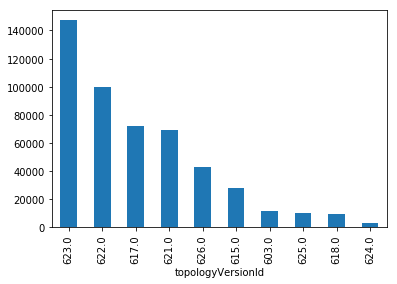

In [26]:
# plot distribution of 'topologyVersionId'
df['topologyVersionId'].value_counts().plot.bar()
plt.xlabel('topologyVersionId')

This graph looks familiar. Distribution looks very similar to 'agencyId'. Let's verify it

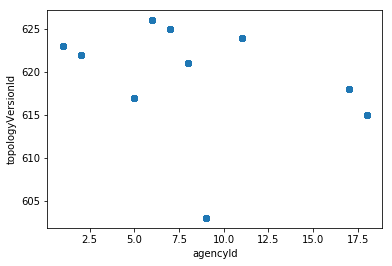

In [27]:
# create scatter plot to see 'agencyId' and 'topologyVersionId' correlation
plt.scatter(df['agencyId'], df['topologyVersionId'])
plt.xlabel('agencyId')
plt.ylabel('topologyVersionId')

There is exacly one 'topologyVersionId' value for each 'agecyId'. This column do not add any new information. I'll remove it from df

In [28]:
# drop 'topologyVersionId' column
df.drop('topologyVersionId', axis=1, inplace=True)

### Location

In [29]:
# read location file
location=pd.read_csv('stops.csv', dtype=column_types)

In [30]:
# check file shape
location.shape

(2495, 3)

In [31]:
# have a look on sampled rows
location.sample(5)

,stopId,stopLat,stopLon
196,1148,54.33443,18.93420
1389,14654,54.34847,18.64223
799,1879,54.35781,18.68661
687,1716,54.41117,18.57296
1858,31655,54.46866,18.30963


In [32]:
# check data types and missing info
location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 3 columns):
stopId     2495 non-null int32
stopLat    2495 non-null float64
stopLon    2495 non-null float64
dtypes: float64(2), int32(1)
memory usage: 48.8 KB


In [33]:
# Check duplicates
location.duplicated(subset='stopId').any()

False

There are 2 new columns containing latitude and longitude of stops. There are no missing data nor duplicates Let's check if all stopIds from df exist in location file

In [34]:
df[~df['stopId'].isin(location['stopId'])]['stopId'].any()

True

There are some stopId existing in df but missing in location file. After merge it will result in missing values. I will look for way to fill it.

In [35]:
# check correlation of stopId with stopLat and stopLon
location.corr()

,stopId,stopLat,stopLon
stopId,1.000000,0.804179,-0.602807
stopLat,0.804179,1.000000,-0.635783
stopLon,-0.602807,-0.635783,1.000000


There is a strong correlation between stopId with stopLat and stopLon. I will use linear regression model to predict missing longitude and latitude

In [36]:
# train linear regression model to predict stopLat
from sklearn.linear_model import LinearRegression
X=location.iloc[:,:1].values
y=location['stopLat'].values
lr_lat=LinearRegression()
lr_lat.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [37]:
# train linear regression model to predict stopLon
X=location.iloc[:,:1].values
y=location['stopLon'].values
lr_lon=LinearRegression()
lr_lon.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [38]:
# find missing stopId, predict it
missing_location=df[~df['stopId'].isin(location['stopId'])]['stopId'].unique().reshape(-1,1)
missing_lon=lr_lon.predict(missing_location)
missing_lat=lr_lat.predict(missing_location)
missing_loc_df=pd.DataFrame({'stopId':np.squeeze(missing_location), 'stopLat':missing_lat, 'stopLon':missing_lon})

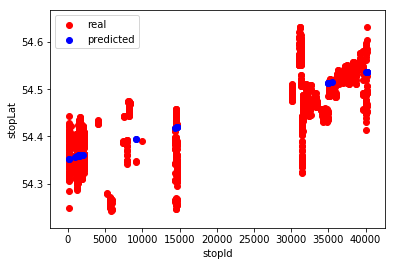

In [39]:
# draw scatter plot see how predictions looks in comparison to real data
plt.scatter(location['stopId'],location['stopLat'],color='red', label='real')
plt.scatter(missing_loc_df['stopId'],missing_loc_df['stopLat'],color='blue', label='predicted')
plt.legend()
plt.xlabel('stopId')
plt.ylabel('stopLat')

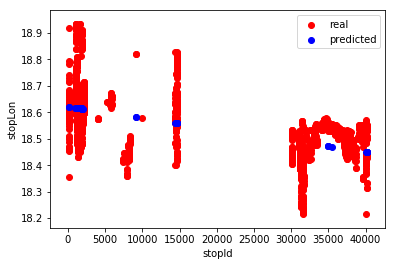

In [40]:
plt.scatter(location['stopId'],location['stopLon'],color='red', label='real')
plt.scatter(missing_loc_df['stopId'],missing_loc_df['stopLon'],color='blue', label='predicted')
plt.legend()
plt.xlabel('stopId')
plt.ylabel('stopLon')

Predictions looks all right. I'll use it to fill missing data.

In [41]:
# add predicted values to location file and merge location with df
location=pd.concat([location,missing_loc_df],axis=0)
df=df.merge(right=location, how='left', left_on=['stopId'], right_on=['stopId'])

### Weather

In [42]:
# read csv file
weather=pd.read_csv('weatherHistory.csv',sep=';')

In [43]:
# check DataFrame shape
weather.shape

(1861, 15)

In [44]:
# have a look on sampled rows
weather.sample(5)

,dt,dt_iso,city_id,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon
1234,1532228400,2018-07-22 03:00:00 +0000 UTC,3099434,288.15,288.15,288.15,1011,87,2,250,0,800,Clear,Sky is Clear,01d
27,1527904800,2018-06-02 02:00:00 +0000 UTC,3099434,288.15,288.15,288.15,1014,93,1,140,24,741,Fog,fog,50n
1594,1533499200,2018-08-05 20:00:00 +0000 UTC,3099434,294.17,294.17,294.17,1023,90,9,286,56,803,Clouds,broken clouds,04n
206,1528545600,2018-06-09 12:00:00 +0000 UTC,3099434,295.15,295.15,295.15,1016,37,4,60,0,800,Clear,Sky is Clear,01d
632,1530072000,2018-06-27 04:00:00 +0000 UTC,3099434,284.15,284.15,284.15,1025,100,2,320,75,741,Fog,fog,50d


In [45]:
# check data types and missing info
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861 entries, 0 to 1860
Data columns (total 15 columns):
dt                     1861 non-null int64
dt_iso                 1861 non-null object
city_id                1861 non-null int64
temp                   1861 non-null float64
temp_min               1861 non-null float64
temp_max               1861 non-null float64
pressure               1861 non-null int64
humidity               1861 non-null int64
wind_speed             1861 non-null int64
wind_deg               1861 non-null int64
clouds_all             1861 non-null int64
weather_id             1861 non-null int64
weather_main           1861 non-null object
weather_description    1861 non-null object
weather_icon           1861 non-null object
dtypes: float64(3), int64(8), object(4)
memory usage: 189.0+ KB


There are 15 columns. Need to check if all are necessary. There are two columns presenting time. One can be dropped, one need to be changed to datatime format. It would be good to change data types to reduce memory usage, not to increase too much size of df after merge. There are no missing values.

In [46]:
# change 'dt' column to datatime format and remove 'dt_iso' column
weather['dt']=pd.to_datetime(weather['dt'],unit='s')
weather.drop(['dt_iso'],axis=1, inplace=True)

In [47]:
# check if there are duplicated rows
weather.duplicated(subset='dt').any()

True

In [48]:
# count duplicated rows
weather.duplicated(subset='dt').sum()

17

 There are 17 duplicated rows- with exact same time. Let's have a look on it.

In [49]:
# show all duplicated rows
weather[weather.duplicated(subset='dt', keep=False)]

,dt,city_id,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon
17,2018-06-01 17:00:00,3099434,294.15,294.15,294.15,1016,77,2,190,40,520,Rain,light intensity shower rain,09d
18,2018-06-01 17:00:00,3099434,294.15,294.15,294.15,1016,77,2,190,40,211,Thunderstorm,proximity thunderstorm,11d
101,2018-06-05 04:00:00,3099434,288.15,288.15,288.15,1007,100,1,360,90,300,Drizzle,light intensity drizzle,09d
102,2018-06-05 04:00:00,3099434,288.15,288.15,288.15,1007,100,1,360,90,701,Mist,mist,50d
522,2018-06-22 16:00:00,3099434,285.15,285.15,285.15,1013,76,6,250,40,520,Rain,light intensity shower rain,09d
523,2018-06-22 16:00:00,3099434,285.15,285.15,285.15,1013,76,6,250,40,211,Thunderstorm,proximity thunderstorm,11d
588,2018-06-25 09:00:00,3099434,289.15,289.15,289.15,1014,82,5,290,75,520,Rain,light intensity shower rain,09d
589,2018-06-25 09:00:00,3099434,289.15,289.15,289.15,1014,82,5,290,75,211,Thunderstorm,proximity thunderstorm,11d
990,2018-07-12 03:00:00,3099434,290.15,290.15,290.15,1012,93,1,0,20,500,Rain,light rain,10d
991,2018-07-12 03:00:00,3099434,290.15,290.15,290.15,1012,93,1,0,20,701,Mist,mist,50d


In [50]:
# check rows before and after duplicates- maybe there is a missing row with missing hour that should be replaced by dupliate
weather[16:19]

,dt,city_id,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon
16,2018-06-01 16:00:00,3099434,296.15,296.15,296.15,1015,64,2,0,0,800,Clear,Sky is Clear,01d
17,2018-06-01 17:00:00,3099434,294.15,294.15,294.15,1016,77,2,190,40,520,Rain,light intensity shower rain,09d
18,2018-06-01 17:00:00,3099434,294.15,294.15,294.15,1016,77,2,190,40,211,Thunderstorm,proximity thunderstorm,11d


Checked few examples. Rows before and after duplicates are correct. I'll remove duplicates and keep first rows.

In [51]:
weather.drop_duplicates(subset='dt', keep='first',inplace=True)

I'll check if all dates form df exist in weather file. Need to add additional column in df with schedule time pesented in hours not minutes

In [52]:
# add new column to df, check if there is some hour missing in weather file
df['dt']=df['scheduleTime'].dt.round('h')
df[~df['dt'].isin(weather['dt'])]['dt'].unique()

array(['2018-07-02T07:00:00.000000000'], dtype='datetime64[ns]')

Found one hour missing in weather file. I'll fill it using forward fill.

In [53]:
# set 'dt' as index and forward fill missing data
weather=weather.set_index(pd.DatetimeIndex(weather['dt']))
weather.drop(['dt'],axis=1, inplace=True)
weather=weather.resample('H').ffill()

I will now analyse which columns may be removed before merge

In [54]:
# check how many unique values are in each column
weather.nunique()

city_id                 1
temp                   39
temp_min               39
temp_max               39
pressure               27
humidity               70
wind_speed             13
wind_deg               46
clouds_all             16
weather_id             13
weather_main            7
weather_description    15
weather_icon           16
dtype: int64

'City_id' is same for every row. I can remove it.

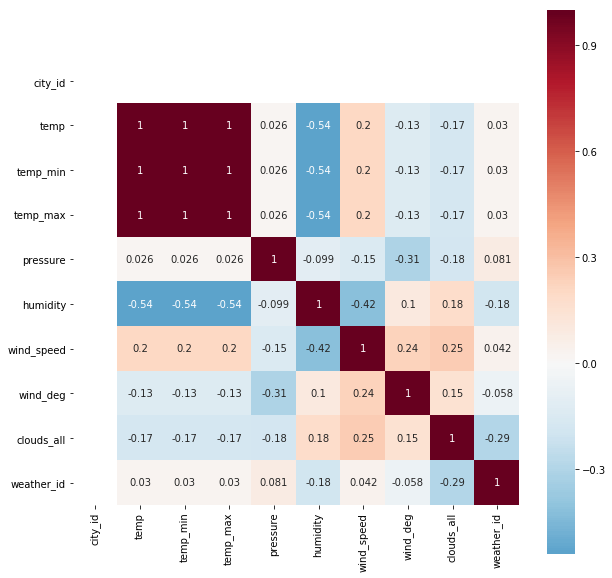

In [55]:
# check correlation between data
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(weather.corr(),cmap='RdBu_r', center=0, square=True,annot=True)

Columns: 'temp', 'temp_max', 'temp_min' are perfectly correlated. I'll leave only 'temp'

In correlation matrix there are only numeric featues. But there also seem to be some correlation between weather_description and weather_id

In [56]:
# check unique 'weather_id' per each 'weather_desription'
weather.groupby('weather_description')['weather_id'].nunique()

weather_description
Sky is Clear                    1
broken clouds                   1
few clouds                      1
fog                             1
light intensity drizzle         1
light intensity shower rain     1
light rain                      1
mist                            1
overcast clouds                 1
proximity thunderstorm          1
scattered clouds                1
shower rain                     1
sky is clear                    1
thunderstorm                    1
thunderstorm with light rain    1
Name: weather_id, dtype: int64

There is one unique 'weather_id' for each weather description. I will leave 'weather_id' column only which is numeric. Let's see if 'weather_id' is also correlated with 'weather_main'

In [57]:
# check unique 'weather_id' per each 'weather_main'
weather.groupby('weather_main')['weather_id'].nunique()

weather_main
Clear           1
Clouds          4
Drizzle         1
Fog             1
Mist            1
Rain            3
Thunderstorm    2
Name: weather_id, dtype: int64

Each of 13 'weather_id' belongs to one 'weather_main' group. 'Weather_main' do not add any new information. I'll remove it.

'Weather_icon' is just an id on icon that is to visualize the weather state. This is based on other features and do not add value. I will remove it as well.

In [58]:
# drop columns mentioned above
weather.drop(['city_id', 'temp_min', 'temp_max','weather_description', 'weather_main', 'weather_icon'], axis=1, inplace=True)

In [59]:
# change data types of chose columns to reduce memory usage
cols= weather.select_dtypes(include=[np.int64, np.float64]).columns
for col in cols: weather[col]=pd.to_numeric(weather[col], downcast='signed')

In [60]:
# check new data types
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1849 entries, 2018-06-01 00:00:00 to 2018-08-17 00:00:00
Freq: H
Data columns (total 7 columns):
temp          1849 non-null float64
pressure      1849 non-null int16
humidity      1849 non-null int8
wind_speed    1849 non-null int8
wind_deg      1849 non-null int16
clouds_all    1849 non-null int8
weather_id    1849 non-null int16
dtypes: float64(1), int16(3), int8(3)
memory usage: 45.1 KB


I will now merge the weather DataFrame with df

In [61]:
# merge Dataframes and dop 'dt' columns which was used to enable merge
df=df.merge(right=weather, how='left', left_on='dt', right_index=True)
df.drop(['dt'], axis=1, inplace=True)

### Check preprocessed frame

All DataFrames have been merged. Let's check how the final df looks like, if there are any missing data or outliers that may be errors.

In [62]:
# have a look on sampled rows
df.head()

,id,stopId,routeId,vehicleId,tripId,delayPredictionTimestamp,scheduleTime,delayInSeconds,stopSequence,agencyId,stopLat,stopLon,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id
0,768,204,11,377,22,2018-06-13 12:10:32,2018-06-13 12:09:00,1384,37.0,2.0,54.39919,18.59498,291.15,1009,59,5,250,75,803
1,777,2096,11,377,22,2018-06-13 12:05:21,2018-06-13 12:05:00,110,34.0,2.0,54.41262,18.58775,291.15,1009,59,5,250,75,803
2,790,2008,11,377,11,2018-06-13 13:39:26,2018-06-13 13:14:00,1561,29.0,2.0,54.36391,18.63838,291.15,1009,59,4,230,40,802
3,798,2024,11,377,11,2018-06-13 13:27:38,2018-06-13 13:01:00,1659,21.0,2.0,54.38220,18.59866,291.15,1009,59,4,230,40,802
4,800,2028,11,377,11,2018-06-13 13:08:41,2018-06-13 12:58:00,721,19.0,2.0,54.38690,18.58521,291.15,1009,59,4,230,40,802


In [63]:
# check missing data
missing_data = pd.DataFrame(df.isnull().any(), columns=['Nulls'])
missing_data['Num_of_nulls [qty]'] = pd.DataFrame(df.isnull().sum())
missing_data['Num_of_nulls [%]'] = round((df.isnull().mean()*100),2)
missing_data

,Nulls,Num_of_nulls [qty],Num_of_nulls [%]
id,False,0,0.0
stopId,False,0,0.0
routeId,False,0,0.0
vehicleId,False,0,0.0
tripId,False,0,0.0
delayPredictionTimestamp,False,0,0.0
scheduleTime,False,0,0.0
delayInSeconds,False,0,0.0
stopSequence,False,0,0.0
agencyId,False,0,0.0


There are no more mising data. I will now analyze outliers and data distributions to look for data that may be incorrect due to human or system errors. I will use 1,5 interquartile rule to identyfy outliers and data profiling report to analyze distributions.

In [64]:
# analyze outliers
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3-q1
low_limit = (q1 - 1.5 * iqr)
upp_limit = (q3 + 1.5 * iqr)
num_of_outliers_L = (df[iqr.index] < low_limit).sum() #iqr.index- to use only numerical features for which iqr was calculated
num_of_outliers_U = (df[iqr.index] > upp_limit).sum()
per_of_outliers_L = num_of_outliers_L/df[iqr.index].count()
per_of_outliers_U = num_of_outliers_U/df[iqr.index].count()
outliers = pd.DataFrame({'num_of_outliers_L':num_of_outliers_L, 'num_of_outliers_U':num_of_outliers_U,
'per_of_outliers_L':per_of_outliers_L, 'per_of_outliers_U':per_of_outliers_U}, 
 columns=['num_of_outliers_L','per_of_outliers_L','num_of_outliers_U','per_of_outliers_U'])
outliers

,num_of_outliers_L,per_of_outliers_L,num_of_outliers_U,per_of_outliers_U
id,0,0.000000,0,0.000000
stopId,0,0.000000,0,0.000000
routeId,0,0.000000,0,0.000000
vehicleId,0,0.000000,118269,0.236538
tripId,0,0.000000,79578,0.159156
delayInSeconds,623,0.001246,43952,0.087904
stopSequence,0,0.000000,5696,0.011392
agencyId,0,0.000000,37137,0.074274
stopLat,0,0.000000,0,0.000000
stopLon,1235,0.002470,6369,0.012738


In [65]:
pandas_profiling.ProfileReport(df)


Number of variables,19
Number of observations,499999
Total Missing (%),0.0%
Total size in memory,44.3 MiB
Average record size in memory,93.0 B
Numeric,16
Categorical,0
Boolean,0
Date,2
Text (Unique),0
Rejected,1


There are outliers in many columns. Columns: 'vehicleId', 'tripId', 'agencyId', 'weatherId' contains IDs. It's normal that such data are not normally distributed and may contain outliers. Outliers of 'stopSequence', 'stopLon', 'wind_speed' are not high percentage of total data. Outliers in 'pressure' and increasing amount of data in right tail are quite suprising, but maximum value of 1028 hPa does not seem to be incorrect data. There are 8,7% of upper outliers in 'delayInSeconds'- the dependant variable. This need to be further investigated. The profile report shown also that there is a high correletion between 'stopId' and 'routeId'. I need to check if both features add some new information.

In [66]:
# check number of unique 'routeId' per 'stopId'.
df.groupby('stopId')['routeId'].nunique().head(10)

stopId
100    1
101    2
102    3
103    1
110    1
114    7
115    8
116    7
117    3
118    5
Name: routeId, dtype: int64

There are few 'routeIds' for most of 'stopIds'. Eveb though data are highly correlated 'routeId' may still add some value. I will leave it. I will now analyze 'delayInSeconds' outliers.

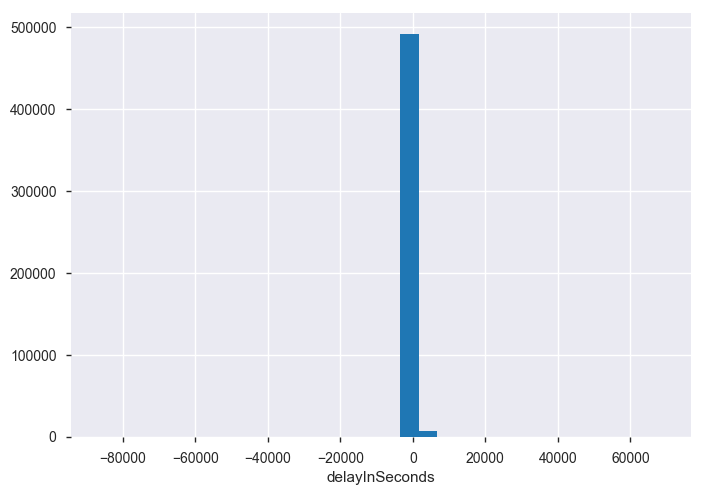

In [67]:
# draw 'delayInSeconds' histogram
df['delayInSeconds'].hist(bins=30)
plt.xlabel('delayInSeconds')

In [68]:
# Show upper limit calculated for 'delayInSeconds' outliers
upp_limit['delayInSeconds']

477.0

Generally buses are supposed to arrive on time. The most of the delays are close to 0. The kurtosis of this distribution is very high. Therefore the outliers upper limit calculated using 1,5 interquartile rule is quite small- around 8 mins. Bus delays exceeding 8 minutes are nothing unusual and I do not consider it to be incorrect data. The real issue seems to be the highest and lowest values as huge as 75000 and -75000. Let's analyze them.

In [69]:
# show outliers over 7000 and below -70000
df[(df['delayInSeconds']>70000) | (df['delayInSeconds']<-70000) ]['delayInSeconds']

8724     -86356
38050    -86429
38252    -86281
47557    -86333
47783    -86379
47840    -86296
98620    -86382
98625    -86395
118887   -86082
119053   -86298
119086   -86226
119087   -86239
137637   -86408
151868   -86298
181009   -86026
181130   -86354
181131   -86365
181132   -86389
195583   -86281
210365   -86357
224445   -86418
224534   -83976
224535   -86382
238543   -86048
267898   -86288
267899   -86289
281999   -86336
296624   -86243
315574   -86254
330137   -86447
330193   -86415
388557   -86423
388621   -86384
398099   -86224
479561   -86030
479585   -86224
Name: delayInSeconds, dtype: int32

All the values are similar. 86400s equal to 24h. This seems to be an error in date. I will analyze if those observaitons have something in common.

In [70]:
# Check time of observations which are incorrect by +/- 24h
df[(df['delayInSeconds']>70000) | (df['delayInSeconds']<-70000) ]['delayPredictionTimestamp']

8724     2018-06-14 03:45:01
38050    2018-06-16 03:45:05
38252    2018-06-16 03:45:04
47557    2018-06-17 03:45:04
47783    2018-06-17 03:45:02
47840    2018-06-17 03:45:04
98620    2018-06-21 03:45:04
98625    2018-06-21 03:45:01
118887   2018-06-23 03:45:01
119053   2018-06-23 03:45:03
119086   2018-06-23 03:45:02
119087   2018-06-23 03:45:02
137637   2018-06-25 03:45:03
151868   2018-06-26 03:45:03
181009   2018-06-28 03:45:01
181130   2018-06-28 03:45:03
181131   2018-06-28 03:45:03
181132   2018-06-28 03:45:03
195583   2018-06-29 03:45:05
210365   2018-06-30 03:45:02
224445   2018-07-02 03:45:04
224534   2018-07-02 03:45:03
224535   2018-07-02 03:45:03
238543   2018-07-03 03:45:00
267898   2018-07-05 03:45:01
267899   2018-07-05 03:45:01
281999   2018-07-06 03:45:01
296624   2018-07-07 03:45:04
315574   2018-07-09 03:45:02
330137   2018-07-10 03:45:01
330193   2018-07-10 03:45:01
388557   2018-07-14 03:45:02
388621   2018-07-14 03:45:01
398099   2018-07-15 03:45:03
479561   2018-

The majority of errors occure on different days but same time - between 3:44:57 and 3:45:05. It's just a few seconds. It's difficult to say what's the reason. Maybe ithere is some clock synchronization happening at this time. If I were to create a real model I would correct those data by adding/removing 24h or remove those data from the train dataset. But as the model is created for competition, the test file would probably also contain such errors, therefore I would leave it and try to predict it. Unfortunately such extreme outliers may affect overall model performance.

I will now save preprocessed df to use it in feature engineering phase.

In [71]:
df.to_csv('df_cleaned', index=False)